# MlFlow Experiment Tracking Setup

In [1]:
import mlflow
mlflow.autolog()
mlflow.set_tracking_uri("http://localhost:8080")
mlflow.set_experiment("Initial Model Evaluation")
mlflow.set_tag("mlflow.runName", "Original_Model")
mlflow.set_experiment_tag

<function mlflow.tracking.fluent.set_experiment_tag(key: str, value: Any) -> None>

# Imports

In [2]:
import os
import cv2
import sys
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.utils.checkpoint import checkpoint_sequential
import torchvision.models as models
import torch.nn as nn
from torchmetrics import Accuracy, Precision, Recall, F1Score
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
import numpy as np

MAIN_DIR = Path("__file__").resolve().parent.parent.parent
CLASSIFICATION_MAPPING_DIR = os.path.join(MAIN_DIR, "classification_mapping") 
if CLASSIFICATION_MAPPING_DIR not in sys.path:
    sys.path.insert(0, CLASSIFICATION_MAPPING_DIR)
from classification_mapping import CLASSIFICATION_MAPPING

DATA_DIR = os.path.join(MAIN_DIR, 'data')
TRANSLATED_DATA_DIR = os.path.join(MAIN_DIR, 'data_original_model_translated')

2025/06/23 17:03:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [3]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


# Loading Dataset

In [4]:
# Function to transform images to 224x224 for ResNet with normalization based on
# original model image normalization settings
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
])

In [5]:
data, labels = [], []

for dir_ in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, dir_)
    translated_path = os.path.join(TRANSLATED_DATA_DIR, dir_)
    if not os.path.exists(translated_path): os.makedirs(translated_path)

    for img in os.listdir(path):
        # Load and transform the image
        image_path = os.path.join(path, img)
        image = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        image_tensor = transform(img_pil)

        data.append(image_tensor)
        labels.append(dir_)
        
        image_pil = to_pil_image(image_tensor)
        image_translated_path = os.path.join(translated_path, img)
        image_pil.save(image_translated_path)

In [6]:
print(len(data))

178


In [7]:
class SignDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = torch.tensor([CLASSIFICATION_MAPPING[label] for label in labels], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    @property
    def classes(self):
        return self.data.classes

In [8]:
dataset = SignDataset(data, labels)
len(dataset)

178

In [9]:
# Stratified K Folde Cross Validation
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Function to Create CNN Model from Pytorch

In [10]:
num_classes = 4

def create_model():
    return CNN()
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            # Convolutional layers
            nn.Conv2d(3, 8, kernel_size=3, padding=1),   # -> (8, 384, 384)
            nn.ReLU(),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),  # -> (16, 384, 384)
            nn.ReLU(),
            nn.MaxPool2d(2),                              # -> (16, 192, 192)

            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # -> (32, 192, 192)
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # -> (64, 192, 192)
            nn.ReLU(),
            nn.MaxPool2d(2),                              # -> (64, 96, 96)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# -> (128, 96, 96)
            nn.ReLU(),
            nn.MaxPool2d(2),                              # -> (128, 48, 48)
            
            nn.Flatten(),                                 # -> 128 * 64 * 64 = 294,912

            # Fully connected layers with dropout
            nn.Linear(128 * 48 * 48, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout applied after first FC ReLU
            
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        # Make sure input requires grad for checkpointing to work
        if not x.requires_grad:
            x.requires_grad = True

        # Divide into N chunks for checkpointing
        chunks = 10  # Can tune this based on memory/speed trade-off
        return checkpoint_sequential(self.net, chunks, x, use_reentrant=False)

# Grid Search Parameters

In [11]:
# Grid Search Parameters
param_grid = {
    'lr': [0.01, 0.001, 0.0001],
    'train_batch_size': [16, 32, 64],
    'test_batch_size': [16],
    'weight_decay': [0.0, 1e-4],
}

In [12]:
# Use itertools.product to iterate through combinations
from itertools import product

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

# Model training

In [13]:
def train(model, optimizer, dataloader, criterion, device):
    model.train()
    for data, labels in dataloader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [14]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            preds = outputs.argmax(dim=1) # still work since log softmax is still highest number as the predicted class
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [15]:
categories = []
accuracies = []
results = []
num_epochs = 40
for params in param_combinations:
    config = dict(zip(param_names, params))
    print(f"Testing params: {config}")
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(data, labels)):
        print(f"Fold {fold+1}")
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=config['train_batch_size'], shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=config['test_batch_size'])

        model = create_model().to(DEVICE)  # Initialize fresh model per fold
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        criterion = torch.nn.CrossEntropyLoss()
        model.to(DEVICE)

        # Train and evaluate
        for epoch in range(num_epochs):  # or another stopping criterion
            train(model, optimizer, train_loader, criterion, DEVICE)

        acc = evaluate(model, val_loader, DEVICE)
        fold_accuracies.append(acc)

    avg_acc = np.mean(fold_accuracies)
    print(f"Average Accuracy: {avg_acc:.4f}")
    results.append((config, avg_acc))
    categories.append(str(config).replace("'", ""))
    accuracies.append(avg_acc)

Testing params: {'lr': 0.01, 'train_batch_size': 16, 'test_batch_size': 16, 'weight_decay': 0.0}
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.2921
Testing params: {'lr': 0.01, 'train_batch_size': 16, 'test_batch_size': 16, 'weight_decay': 0.0001}
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.2865
Testing params: {'lr': 0.01, 'train_batch_size': 32, 'test_batch_size': 16, 'weight_decay': 0.0}
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.2921
Testing params: {'lr': 0.01, 'train_batch_size': 32, 'test_batch_size': 16, 'weight_decay': 0.0001}
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.3143
Testing params: {'lr': 0.01, 'train_batch_size': 64, 'test_batch_size': 16, 'weight_decay': 0.0}
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.3033
Testing params: {'lr': 0.01, 'train_batch_size': 64, 'test_batch_size': 16, 'weight_decay': 0.0001}
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Average Accuracy: 0.3035
Testing params: {'lr': 0.001, 'train_batch_size':

# Visualize

C:\Users\Phuong Hoang Dinh\AppData\Local\Temp\ipykernel_4332\345311558.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


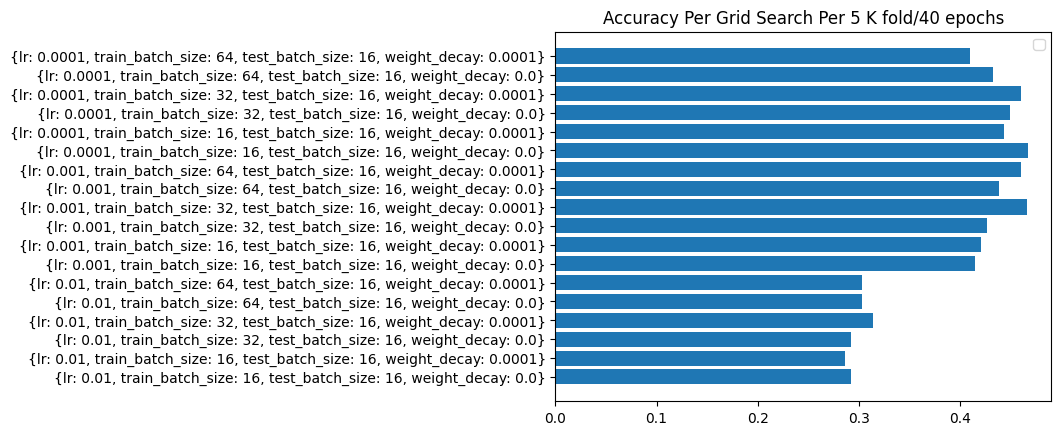

In [16]:
plt.barh(categories, accuracies)
plt.legend()
plt.title("Accuracy Per Grid Search Per 5 K fold/40 epochs")
plt.show()

# Model Evaluation Logging

In [17]:
# Log result
for category, accuracy in zip(categories, accuracies):
    mlflow.log_metric(category.replace("'", "").replace("{","").replace("}","").replace(": ", "").replace(", ", " "), accuracy)